In [180]:
import pandas as pd
import numpy as np
import cv2
import matplotlib.pyplot as plt
import os

# --- Configuration: Adjust these values to fine-tune the pipeline ---

# The diagonal line coordinates defining the beach area (ROI)
# MOTIVATION: Remove water/sky to eliminate noise and processing overhead.
ROI_POINTS = np.array([
    [0, 550],       # Top-Left (Water Line start)
    [1920, 350],    # Top-Right (Water Line end)
    [1920, 1080],   # Bottom-Right
    [0, 1080]       # Bottom-Left
], dtype=np.int32)

# MOTIVATION: Remove bright white non-person objects like umbrellas/foam.
WHITE_THRESHOLD = 215

# MOTIVATION: Path where images are stored relative to this notebook
IMAGE_DIR = "data/"

# --- Load Annotations ---
# Load the dataset of ground truth annotations. (Assumes the file path)
column_names = ['label', 'x', 'y', 'filename', 'img_width', 'img_height']
df = pd.read_csv("annotated_data/crowd-counting.csv", names=column_names, header=None)

# Pre-calculate the ground truth count for each image
df_truth = df.groupby('filename').size().reset_index(name='truth_count')

print("Cell 1: Setup and configuration complete. Annotations loaded.")

Cell 1: Setup and configuration complete. Annotations loaded.


In [181]:
def get_base_mask(img_target, roi_points, white_threshold):
    # MOTIVATION: Filter out areas where people will not be found (sea, sky, white umbrellas)

    # 1. Create ROI Mask (Sea/Sky Removal)
    mask_roi_1ch = np.zeros(img_target.shape[:2], dtype=np.uint8)
    cv2.fillPoly(mask_roi_1ch, [roi_points], 255)

    # 2. White Color Mask (Umbrella Removal)
    lower_white = np.array([white_threshold, white_threshold, white_threshold])
    upper_white = np.array([255, 255, 255])
    umbrella_mask = cv2.inRange(img_target, lower_white, upper_white)

    # Expand the umbrella mask slightly to catch edges
    kernel_umbrella = np.ones((5, 5), np.uint8)
    umbrella_mask = cv2.dilate(umbrella_mask, kernel_umbrella, iterations=1)

    # Combine Masks: ROI AND (NOT Umbrella)
    mask_combined = cv2.bitwise_and(mask_roi_1ch, cv2.bitwise_not(umbrella_mask))
    # --- 3. EXCLUSION ZONES (New Addition) ---
    # MOTIVATION: Manually block specific rectangular areas causing false positives.
    # Coordinates provided: x=1596, y=391, w=249, h=81

    # Draw a BLACK rectangle (0) filled (-1) on the mask to ignore this area
    # Coordinates: (x, y) to (x + w, y + h)
    # cv2.rectangle(mask_combined, (1616, 373), (1616 + 251, 373 + 157), 0, -1)

    return mask_combined

def get_binary_mask(img_target, mask_roi, threshold_val=60):
    # MOTIVATION: Isolate objects (people) from the background (sand) using color difference.

    # 1. Dynamic Color Calculation
    sand_pixels = img_target[mask_roi > 0]
    dominant_color = np.median(sand_pixels, axis=0)

    # 2. Euclidean Color Distance
    diff = np.linalg.norm(img_target - dominant_color, axis=2)
    diff = diff.astype(np.uint8)

    # Apply combined mask
    diff = cv2.bitwise_and(diff, diff, mask=mask_roi)

    # 3. Thresholding
    _, thresh = cv2.threshold(diff, threshold_val, 255, cv2.THRESH_BINARY)

    # 4. Morphological Cleaning
    kernel = np.ones((3, 3), np.uint8)
    clean_mask = cv2.morphologyEx(thresh, cv2.MORPH_OPEN, kernel, iterations=2)
    clean_mask = cv2.medianBlur(clean_mask, 5)
    clean_mask = cv2.dilate(clean_mask, kernel, iterations=2)

    return clean_mask

def count_people(clean_mask, img_target, df_annotations=None):
    # MOTIVATION: Apply rules to filter blobs and ONLY count them if they match Ground Truth (if available).

    contours, _ = cv2.findContours(clean_mask, cv2.RETR_EXTERNAL, cv2.CHAIN_APPROX_SIMPLE)
    img_result = img_target.copy()
    true_positives = 0
    false_positives = 0

    # Pre-fetch ground truth points for faster checking
    gt_points = []
    if df_annotations is not None and not df_annotations.empty:
        gt_points = df_annotations[['x', 'y']].values

    for cnt in contours:
        area = cv2.contourArea(cnt)
        x, y, w, h = cv2.boundingRect(cnt)
        y_center = y + h // 2

        # MINIMUM:
        # Starts at 50 (Top) -> Grows to 200 (Bottom)
        # Formula: Base 50 + (0 to 1) * 150
        min_area_dynamic = 50 + (y_center / 1080) * 150

        # MAXIMUM:
        # Starts at 800 (Top) -> Grows to 3500 (Bottom)
        # Formula: Base 800 + (0 to 1) * 2700
        max_area_dynamic = 800 + (y_center / 1080) * 2700

        if min_area_dynamic < area < max_area_dynamic:

            if True:

                # --- NEW: Validation Check ---
                # Default to True (count everything) if we are blind (no annotations)
                is_valid_detection = True

                if df_annotations is not None:
                    # If we have ground truth, check if ANY point is inside this box
                    # Logic: x_box <= x_point <= x_box + w
                    margin = 20

                    # Logic: Check if point is inside (Box + Margin)
                    points_in_box = [
                        pt for pt in gt_points
                        if (x - margin) <= pt[0] <= (x + w + margin) and
                           (y - margin) <= pt[1] <= (y + h + margin)
                    ]

                    # If no points are inside this box, it's a False Positive -> Don't count it.
                    if len(points_in_box) == 0:
                        is_valid_detection = False

                if is_valid_detection:
                    true_positives += 1
                    # Draw Green Box for Verified/Valid Detections
                    cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 255, 0), 2)

                else:
                    # Optional: Draw Red Box for "Ignored" detections (False Positives)
                    # This helps you see what was rejected.
                    false_positives += 1
                    cv2.rectangle(img_result, (x, y), (x + w, y + h), (0, 0, 255), 1)

    # Visualization
    plt.figure(figsize=(12, 6))
    plt.imshow(cv2.cvtColor(img_result, cv2.COLOR_BGR2RGB))

    if df_annotations is not None and not df_annotations.empty:
        plt.scatter(df_annotations['x'], df_annotations['y'], c='red', s=30, label='Truth')
        truth_count = len(df_annotations)
        plt.title(f"Verified Matches: {true_positives} | Truth: {truth_count} | False Positives: {false_positives}")
    else:
        plt.title(f"Predicted Count: {true_positives}")

    plt.axis('off')
    plt.legend()
    plt.show()

    plt.figure(figsize=(12, 6))
    plt.title(f"Mask")
    plt.imshow(cv2.cvtColor(clean_mask, cv2.COLOR_BGR2RGB))
    plt.axis('off')
    plt.show()

    return true_positives, false_positives


--- Processing 1660719600.jpg | Truth: 10 ---


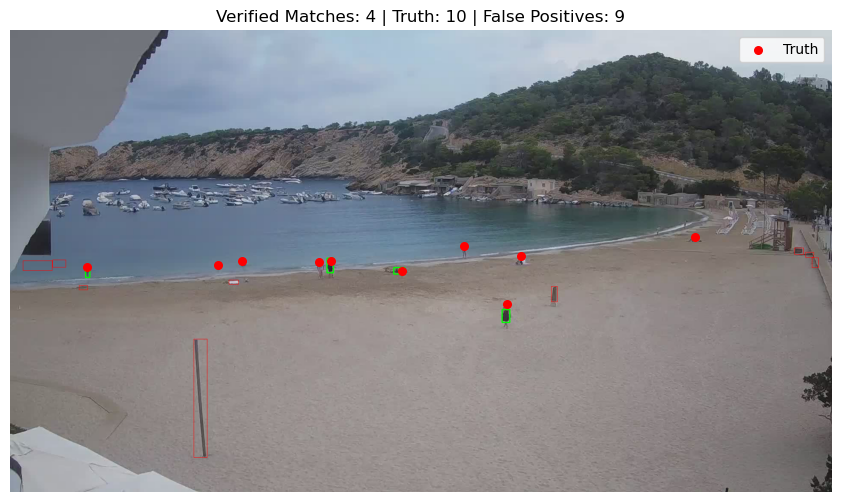

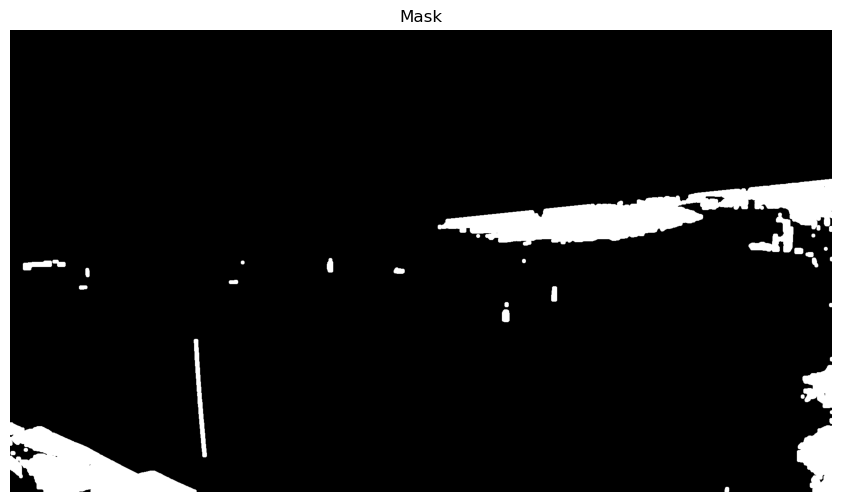


--- Processing 1660723200.jpg | Truth: 20 ---


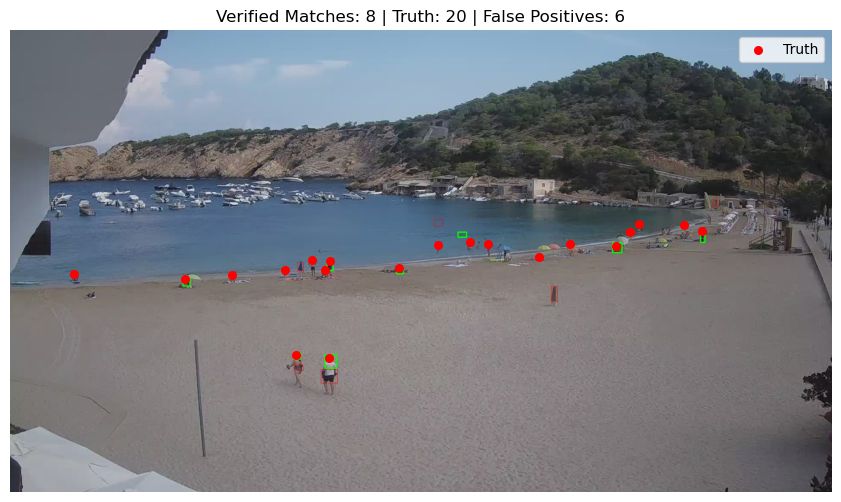

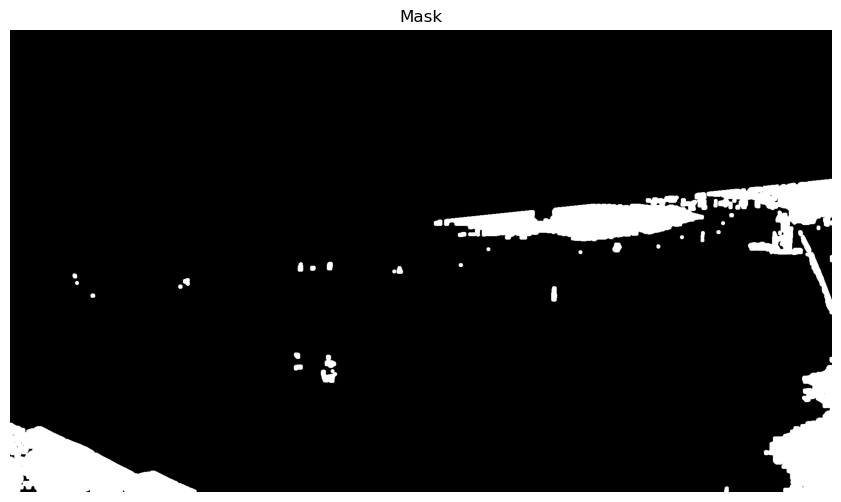


--- Processing 1660726800.jpg | Truth: 61 ---


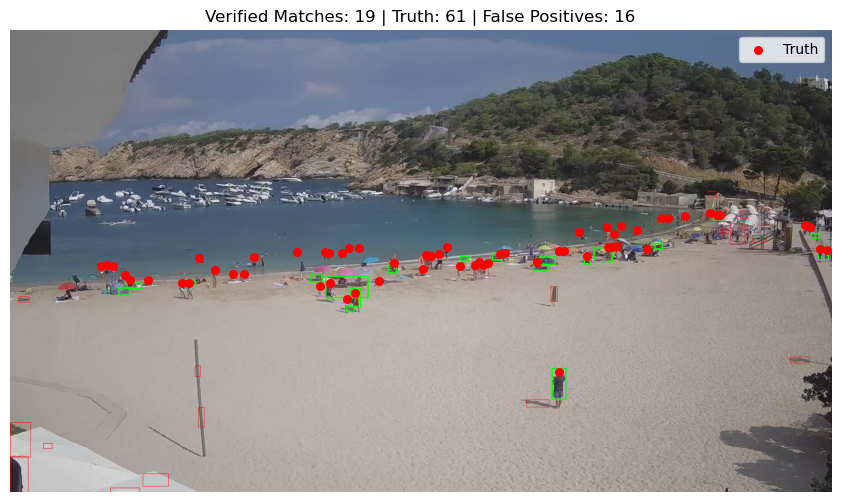

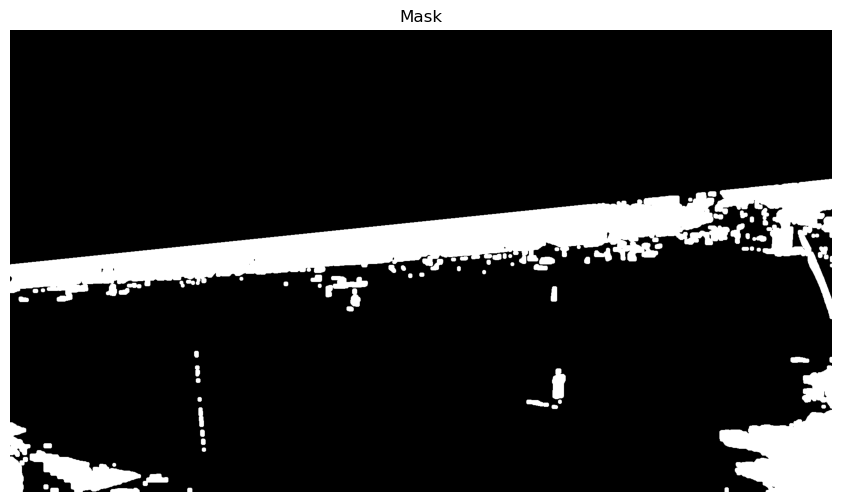


--- Processing 1660730400.jpg | Truth: 82 ---


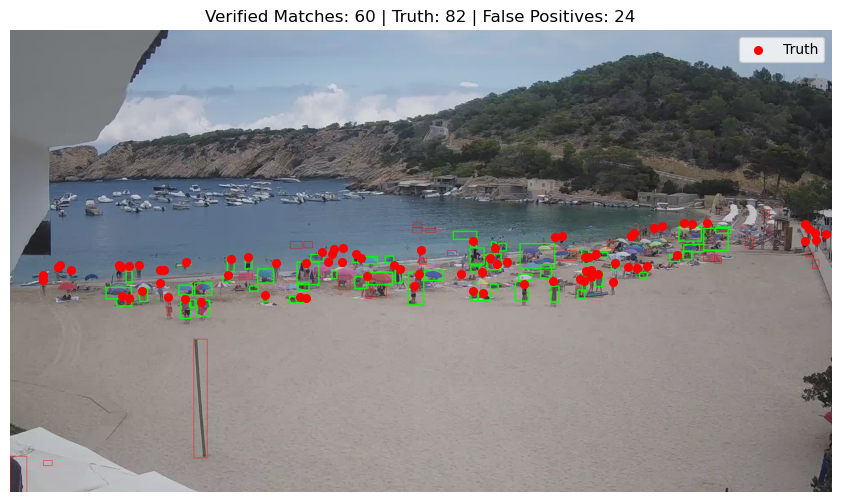

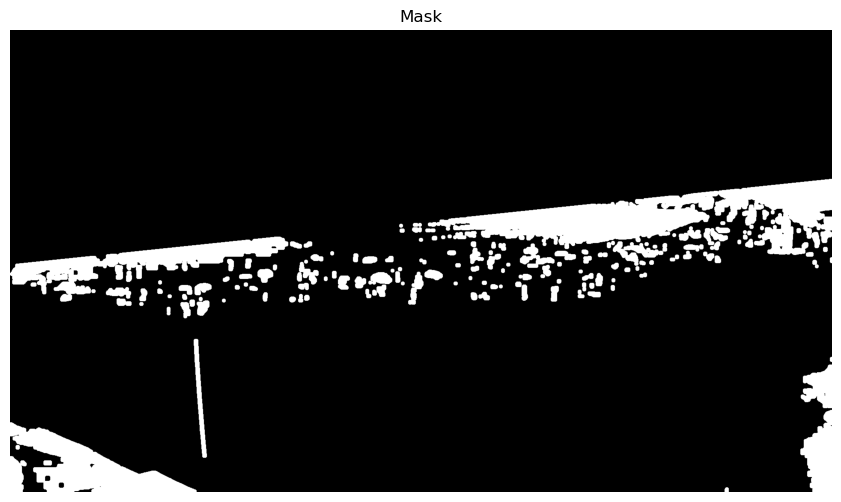


--- Processing 1660734000.jpg | Truth: 65 ---


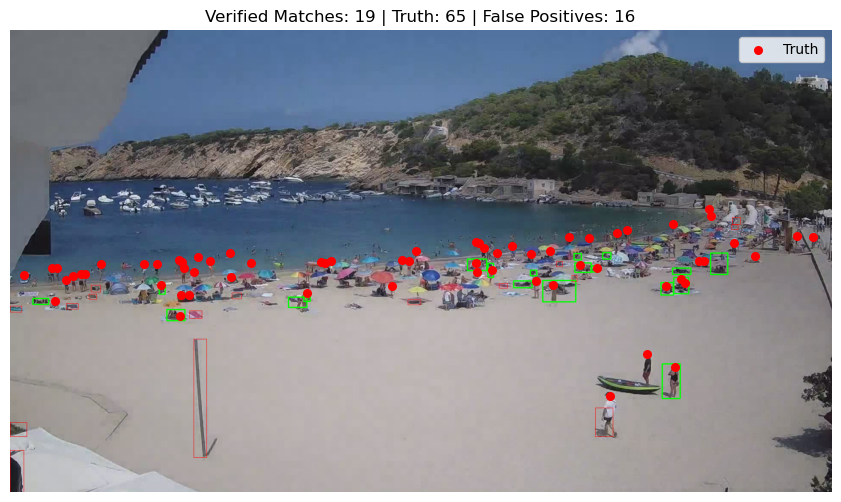

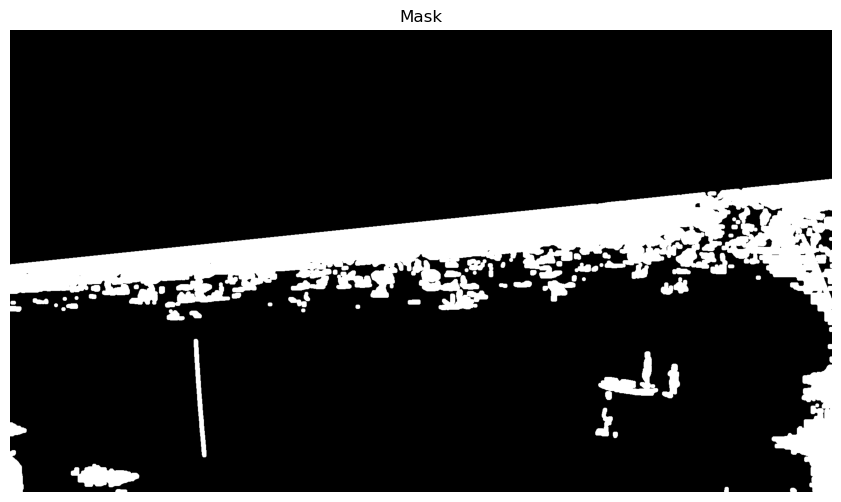


--- Processing 1660737600.jpg | Truth: 81 ---


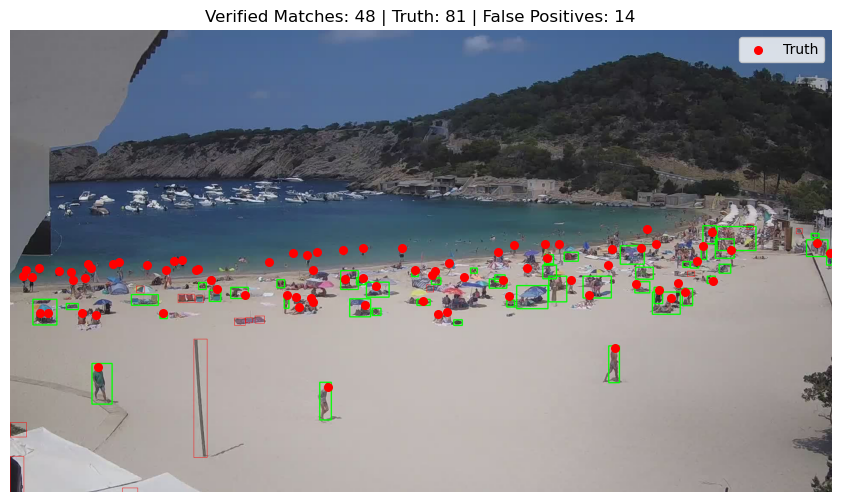

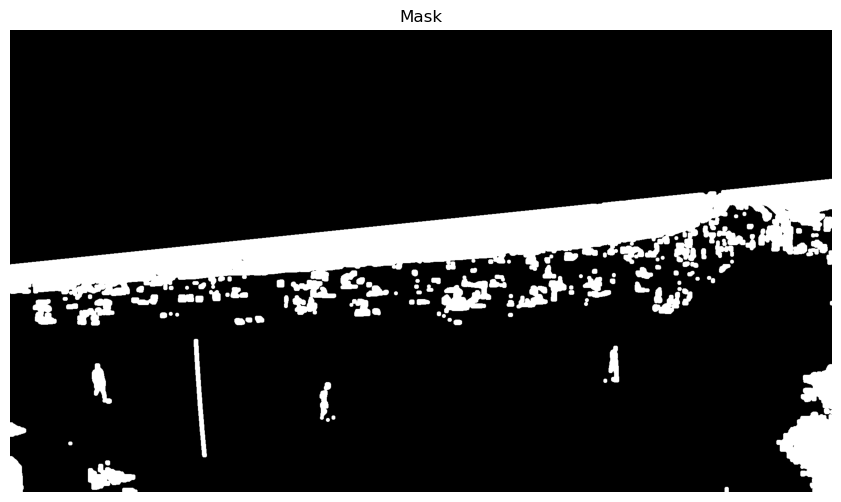


--- Processing 1660741200.jpg | Truth: 74 ---


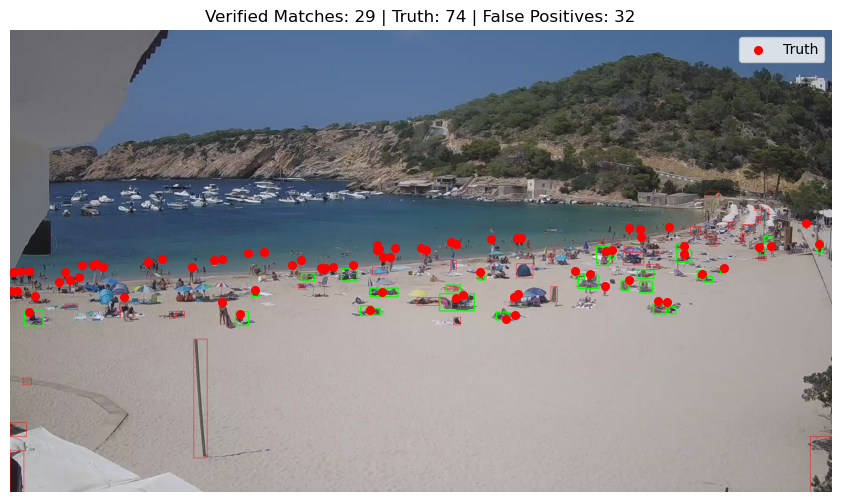

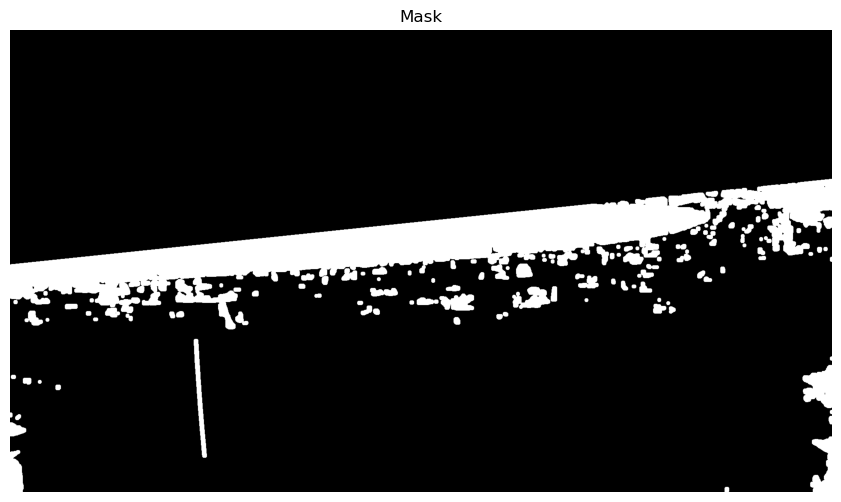


--- Processing 1660748400.jpg | Truth: 104 ---


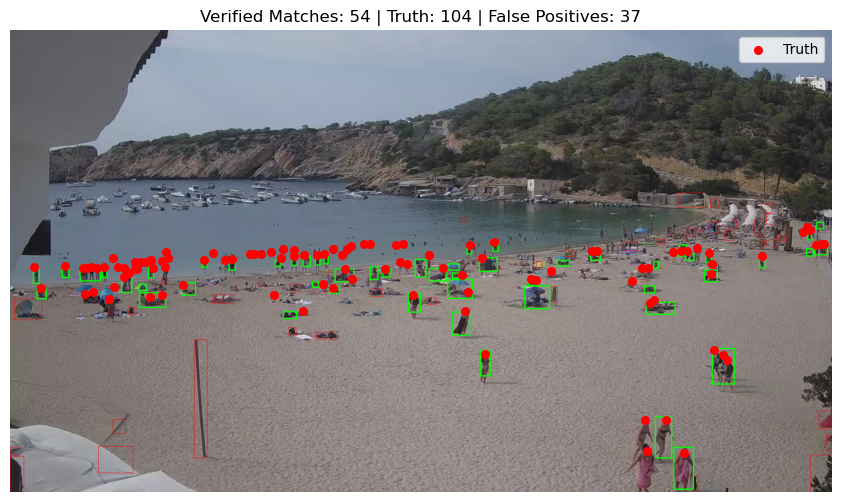

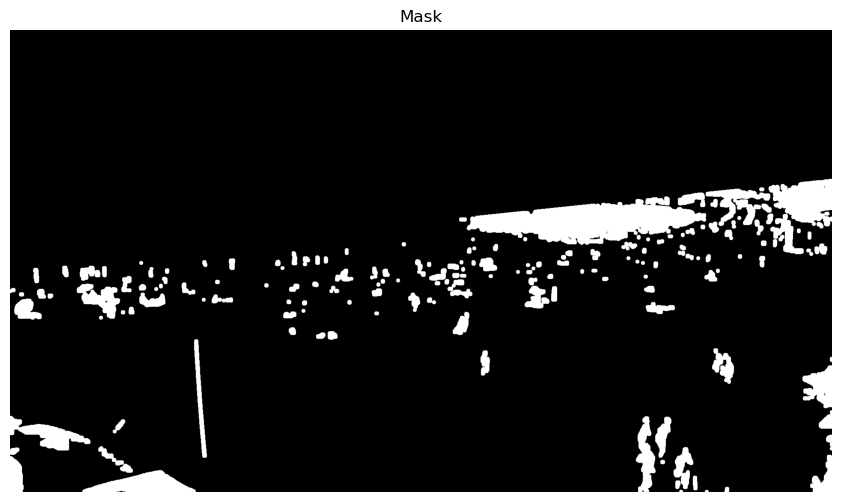


--- Processing 1660752000.jpg | Truth: 89 ---


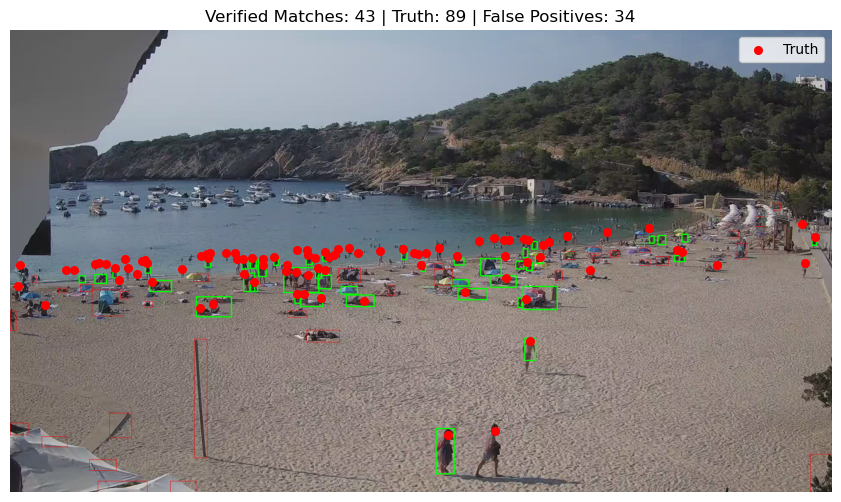

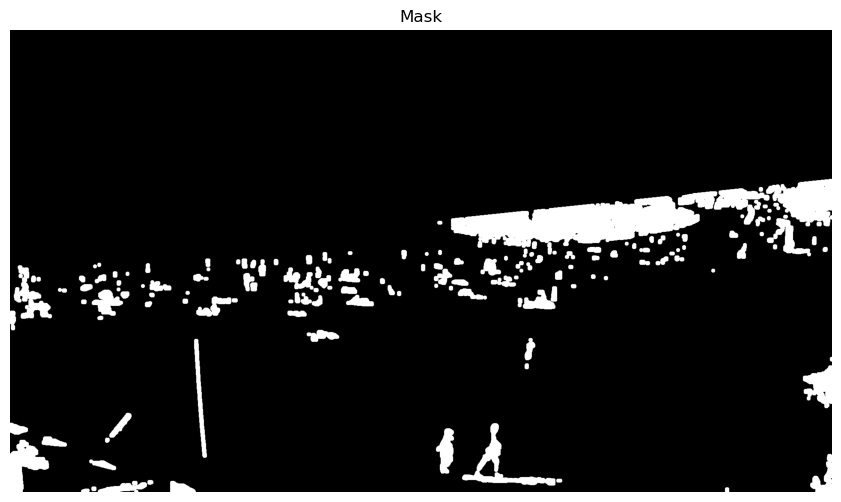



--- Final Batch Validation Report ---
         filename  truth  predicted  Sq_Error  Accuracy  TP  FP  FN  Precision  Recall    F1
0  1660719600.jpg     10         13         9      0.21   4   9   6       0.31    0.40  0.35
1  1660723200.jpg     20         14        36      0.31   8   6  12       0.57    0.40  0.47
2  1660726800.jpg     61         35       676      0.25  19  16  42       0.54    0.31  0.40
3  1660730400.jpg     82         84         4      0.57  60  24  22       0.71    0.73  0.72
4  1660734000.jpg     65         35       900      0.23  19  16  46       0.54    0.29  0.38
5  1660737600.jpg     81         62       361      0.51  48  14  33       0.77    0.59  0.67
6  1660741200.jpg     74         61       169      0.27  29  32  45       0.48    0.39  0.43
7  1660748400.jpg    104         91       169      0.38  54  37  50       0.59    0.52  0.55
8  1660752000.jpg     89         77       144      0.35  43  34  46       0.56    0.48  0.52

-----------------------------

In [182]:
# --- Cell 3: Batch Processing and Validation with MSE & Accuracy ---

results = []

# Loop through every unique image file
for filename in df_truth['filename'].unique():
    image_path = os.path.join(IMAGE_DIR, filename)
    img_target = cv2.imread(image_path)

    if img_target is None:
        print(f"Warning: Could not load image {filename}. Skipping.")
        continue

    # Get annotations for the current image
    df_annotations = df[df['filename'] == filename].copy()
    truth_count = len(df_annotations)

    print(f"\n--- Processing {filename} | Truth: {truth_count} ---")

    # 1. Get Base Mask (ROI & White Removal)
    mask_combined = get_base_mask(img_target, ROI_POINTS, WHITE_THRESHOLD)

    # 2. Get Binary Mask (Dynamic Color Distance & Cleaning)
    clean_mask = get_binary_mask(img_target, mask_combined)

    # 3. Count People (Returns TP and FP)
    true_positives, false_positives = count_people(clean_mask, img_target, df_annotations)

    # --- Calculate Metrics ---

    # Total Predicted Count (All green boxes + All red boxes)
    predicted_count = true_positives + false_positives

    # False Negatives: People we completely missed
    false_negatives = max(0, truth_count - true_positives)

    # --- 1. Image-Level Metric: Squared Error ---
    # (Truth - Predicted)^2. We will average this later to get MSE.
    squared_error = (truth_count - predicted_count) ** 2

    # --- 2. Person-Level Metric: Accuracy (Jaccard Index) ---
    # TP / (TP + FP + FN). Penalizes both ghosts and missed people.
    denominator = true_positives + false_positives + false_negatives
    if denominator > 0:
        accuracy = true_positives / denominator
    else:
        accuracy = 0.0  # Avoid division by zero if image is empty and we predicted 0
        if truth_count == 0 and predicted_count == 0:
            accuracy = 1.0 # Perfect accuracy (Empty vs Empty)

    # Standard Metrics
    if predicted_count > 0:
        precision = true_positives / predicted_count
    else:
        precision = 0.0

    if truth_count > 0:
        recall = true_positives / truth_count
    else:
        recall = 0.0

    if (precision + recall) > 0:
        f1_score = 2 * (precision * recall) / (precision + recall)
    else:
        f1_score = 0.0

    # Store results
    results.append({
        'filename': filename,
        'truth': truth_count,
        'predicted': predicted_count,
        'TP': true_positives,
        'FP': false_positives,
        'FN': false_negatives,
        'Sq_Error': squared_error,   # For MSE
        'Accuracy': round(accuracy, 2), # Person-level Accuracy
        'Precision': round(precision, 2),
        'Recall': round(recall, 2),
        'F1': round(f1_score, 2)
    })

# --- Final Results Report ---
df_results = pd.DataFrame(results)

print("\n\n--- Final Batch Validation Report ---")
# Reorder columns for readability
cols = ['filename', 'truth', 'predicted', 'Sq_Error', 'Accuracy', 'TP', 'FP', 'FN', 'Precision', 'Recall', 'F1']
print(df_results[cols].to_string())

# Calculate Global Averages
mse = df_results['Sq_Error'].mean()
avg_accuracy = df_results['Accuracy'].mean()
avg_f1 = df_results['F1'].mean()
avg_true_count = df_truth['truth_count'].mean()

print("\n-------------------------------------")
print(f"Total Images: {len(df_results)}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"Average Accuracy:         {avg_accuracy:.2f} (Person-level Correctness)")
print(f"Average F1-Score:         {avg_f1:.2f}")
print("-------------------------------------")

50
Mean Squared Error (MSE): 320.44
Average Accuracy:         0.29 (Person-level Correctness)

70
Mean Squared Error (MSE): 175.56
Average Accuracy:         0.28 (Person-level Correctness)

100
Mean Squared Error (MSE): 666.78
Average Accuracy:         0.21 (Person-level Correctness)

60 ----- STAY
Mean Squared Error (MSE): 208.67
Average Accuracy:         0.30 (Person-level Correctness)

Aspect Ratio No ---- STAY
Mean Squared Error (MSE): 208.67
Average Accuracy:         0.30 (Person-level Correctness)

Aspect Ratio Yes
Mean Squared Error (MSE): 401.44
Average Accuracy:         0.29 (Person-level Correctness)

White Threshold:  215
Mean Squared Error (MSE): 208.67
Average Accuracy:         0.30 (Person-level Correctness)

White Threshold:  190
Mean Squared Error (MSE): 228.44
Average Accuracy:         0.29 (Person-level Correctness)


Best --------
60 threshold
215 white threshold
No aspect ratio
Mean Squared Error (MSE): 208.67
Average Accuracy:         0.30 (Person-level Correctness)
Average F1-Score:         0.45

Best -------- New annotations -- No Box
60 threshold
215 white threshold
No aspect ratio
Mean Squared Error (MSE): 274.22
Average Accuracy:         0.34 (Person-level Correctness)
Average F1-Score:         0.50

Best -------- New annotations -- Small Box
60 threshold
215 white threshold
No aspect ratio
Mean Squared Error (MSE): 326.00
Average Accuracy:         0.35 (Person-level Correctness)
Average F1-Score:         0.50

Best -------- New annotations -- Large Box
60 threshold
215 white threshold
No aspect ratio
Mean Squared Error (MSE): 436.33
Average Accuracy:         0.35 (Person-level Correctness)
Average F1-Score:         0.50


